In [3]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import pandas as pd
import numpy as np
import tqdm, datetime, pickle
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import ngboost as ngb

from sklearn import datasets

import plotnine
from plotnine import *

import seaborn as sns

import os, time

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten

In [4]:
data_train = pd.read_csv("preprocessedDataset/pre1.csv")
numerical_category_fewValues = [
    "homeOwnership", 
    "verificationStatus",
    "initialListStatus",
    "applicationType",
    "n11",
    "n12",
]
numerical_category_manyValues = [
    "regionCode",
    "employmentTitle",
    "purpose",
    "postCode",
    "title",
]
date_type = [
    'issueDate',
    'earliesCreditLine',
    'issueDateDT',
    'earliesCreditLineDT',
    'earliesCreditLineYear',
    'earliesCreditLineMonth',
    'issueYear',
    'issueMonth'
]
numerical_serial = [
    "loanAmnt","interestRate","installment","annualIncome","dti","delinquency_2years","ficoRangeLow","ficoRangeHigh","openAcc",
    "pubRec","pubRecBankruptcies","revolBal","revolUtil","totalAcc","n0","n1","n2","n3",
    "n4","n5","n6","n7","n8","n9","n10","n13","n14",
    "term", 
]
object_serial = [
    "grade",
    "subGrade", 
    "employmentLength"
]

In [5]:
features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode", "issueDate", "earliesCreditLine"] and '_outliers' not in f]
y_full = data_train['isDefault']
x_full = data_train[features]

In [6]:
from sklearn.model_selection import train_test_split

X_, X_test, y_, y_test = train_test_split(x_full, y_full, test_size=0.5, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.6, random_state=0)
del X_, y_

In [7]:
data_train.isnull()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n11,n12,n13,n14,issueYear,issueMonth,earliesCreditLineYear,earliesCreditLineMonth,issueDateDT,earliesCreditLineDT
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
799996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
799997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
799998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
from sklearn.model_selection import train_test_split

def save_dmatrix_1(all_feas, feas_cols_v2, target_label, dmtrx_fname, dmtrx_dir = ""):
    '''
    保存的dmatrix的名字可以自定义。
    '''
    from sklearn.model_selection import train_test_split
    y = all_feas[target_label]
    train, test = train_test_split(all_feas, test_size=0.25, random_state=30, shuffle=True, stratify=y)
    
    import xgboost as xgb
    
    all_train_matrix = xgb.DMatrix(
        train[feas_cols_v2].values, 
        train[target_label].values,
        feature_names=feas_cols_v2
    )
    all_train_matrix.save_binary(
        os.path.join(dmtrx_dir, f"{dmtrx_fname}--train")
    ) # (f'train_matrix_dongzhi_v1-{target_label}')
    
    all_test_matrix = xgb.DMatrix(
        test[feas_cols_v2].values, 
        test[target_label].values,
        feature_names=feas_cols_v2
    )
    all_test_matrix.save_binary(
        os.path.join(dmtrx_dir, f"{dmtrx_fname}--test")
    ) # (f'test_matrix_dongzhi_v1-{target_label}')
    
    del train, all_train_matrix, test, all_test_matrix
    import gc
    gc.collect()
    
    return

def save_dmatrix(all_feas, feas_cols_v2, target_label):
    from sklearn.model_selection import train_test_split
    y = all_feas[target_label]
    train, test = train_test_split(all_feas, test_size=0.25, random_state=30, shuffle=True, stratify=y)
    
    import xgboost as xgb
    
    all_train_matrix = xgb.DMatrix(
        train[feas_cols_v2].values, 
        train[target_label].values,
        feature_names=feas_cols_v2
    )
    all_train_matrix.save_binary(f'train_matrix_dongzhi_v1') # (f'train_matrix_dongzhi_v1-{target_label}')
    
    all_test_matrix = xgb.DMatrix(
        test[feas_cols_v2].values, 
        test[target_label].values,
        feature_names=feas_cols_v2
    )
    all_test_matrix.save_binary(f'test_matrix_dongzhi_v1') # (f'test_matrix_dongzhi_v1-{target_label}')
    
    del train, all_train_matrix, test, all_test_matrix
    import gc
    gc.collect()
    
    return

def train_model_with_different_label(target_label):

    dtrain = xgb.DMatrix(data=f'train_matrix_dongzhi_v1') # (data=f'train_matrix_dongzhi_v1-{target_label}')
    dtest = xgb.DMatrix(data=f'test_matrix_dongzhi_v1') # (data=f'test_matrix_dongzhi_v1-{target_label}')
    
    params={
            'booster':'gbtree',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 5,
            'scale_pos_weight': 3,
            'learning_rate': 0.1, 
            'reg_lambda': 5,
            'reg_alpha': 0, 
            'colsample_bytree': 0.8,
            # 'tree_method': 'gpu_hist', # 'gpu_exact',
#             "gpu_id":7,
        }
#     params['nthread'] = 25
    train_start_time = time.time()
    booster_maidian = xgb.train(params, dtrain, num_boost_round=20, evals=[(dtrain, 'train'), (dtest, 'test')],
                                                      early_stopping_rounds=50,verbose_eval=10)
    train_end_time = time.time()
    
    print(f"train time: {train_end_time - train_start_time}")
    
    if not os.path.exists("trained_models"):
        os.makedirs("trained_models")
    return booster_maidian


def train_model_with_different_label_1(data_dir, data_name):

    dtrain = xgb.DMatrix(
        data=os.path.join(data_dir, f'{data_name}--train')
    )
    dtest = xgb.DMatrix(
        data=os.path.join(data_dir, f'{data_name}--test')
    )
    
    params={
            'booster':'gbtree',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 5,
            'scale_pos_weight': 3,
            'learning_rate': 0.1, 
            'reg_lambda': 5,
            'reg_alpha': 0, 
            'colsample_bytree': 0.8,
#             'tree_method': 'gpu_exact',
#             "gpu_id": 5,
        }
#     params['nthread'] = 25
    train_start_time = time.time()
    booster_maidian = xgb.train(params, dtrain, num_boost_round=20, evals=[(dtrain, 'train'), (dtest, 'test')],
                                                      early_stopping_rounds=50,verbose_eval=10)
    train_end_time = time.time()
    
    print(f"train time: {train_end_time - train_start_time}")
    
    if not os.path.exists("trained_models"):
        os.makedirs("trained_models")
    return booster_maidian

特征选择的方法：
* 相关性筛选：相关性太高的去掉一些
* 用小模型来先训练一下，留下重要性高的
* ~~IV，WOE筛选~~
* 其他算法：双向筛选，退火算法之类的
* selectkbest，pca，LDA之类的降维算法

# 相关性

先根据相关性把高度相关的特征去掉一些。

## 简单地筛选

从某些网站上参考到的，可用性存疑ho。

选出这样的特征：有一个及以上特征与其相关性较大。

这些就是高相关特征。

In [6]:
correlation_matrix = pd.DataFrame(X_train).corr()

In [9]:
correlated_features = set()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [10]:
correlated_features

{'earliesCreditLineDT',
 'ficoRangeHigh',
 'grade',
 'installment',
 'issueDateDT',
 'n10',
 'n2',
 'n3',
 'n4',
 'n7',
 'n8',
 'n9',
 'subGrade'}

## 利用图来展示

只要两个特征之间的相关性高于某一阈值，就增加一条无向边，然后作图

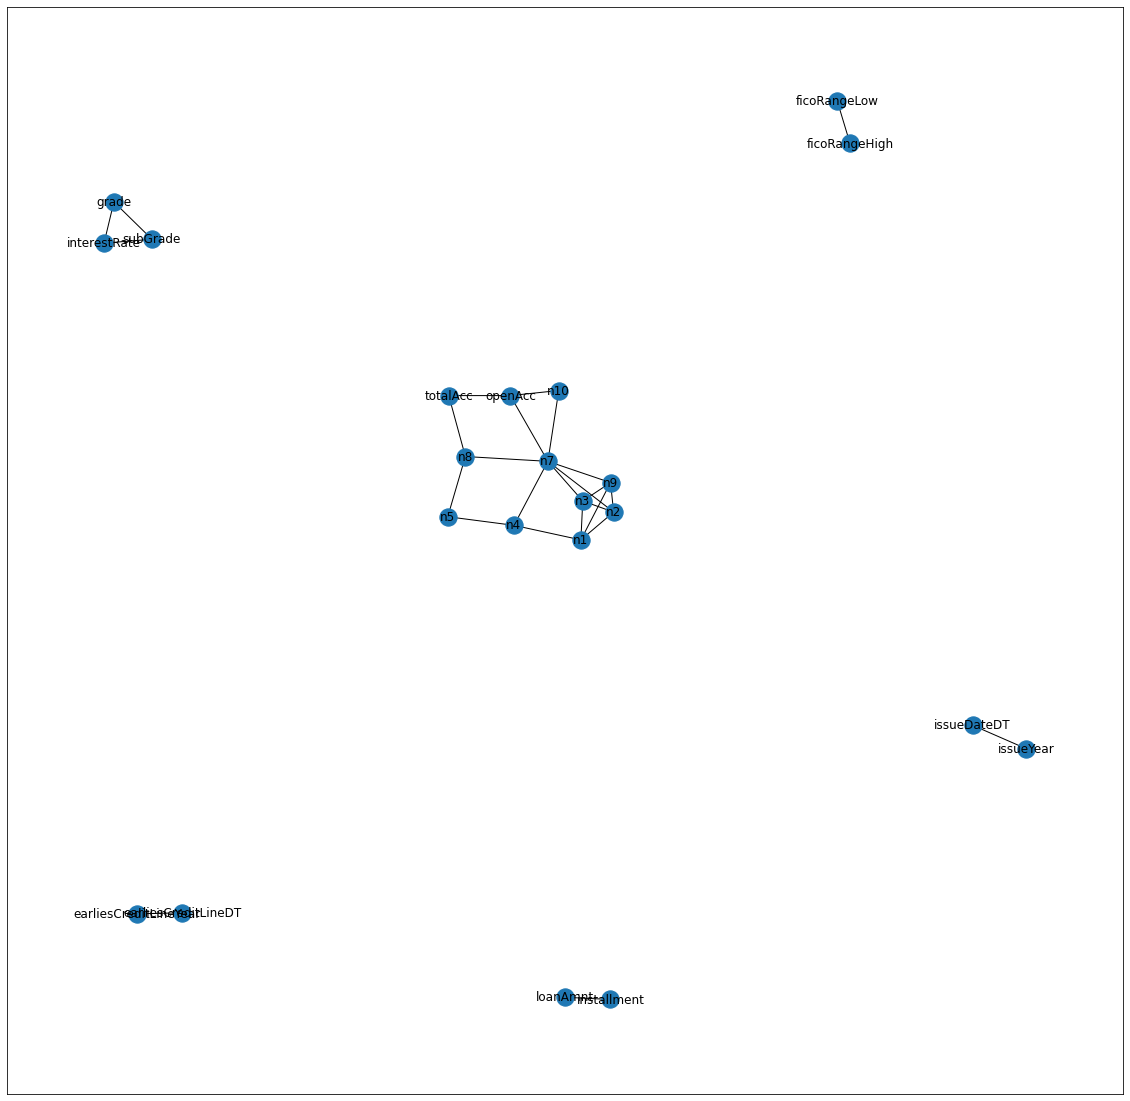

In [42]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

CORR_THRESHOLD = 0.7

G = nx.Graph()

Matrix = (correlation_matrix > CORR_THRESHOLD).values
for i in range(len(Matrix)):
    for j in range(i + 1, len(Matrix)):
        if Matrix[i, j]:
            G.add_edge(cols[i], cols[j])
plt.figure(figsize=(20, 20))
nx.draw_networkx(G)
plt.show()

# ————————————————
# 版权声明：本文为CSDN博主「zy20150613」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
# 原文链接：https://blog.csdn.net/zy20150613/article/details/79645285

# 特征重要性筛选

然后再拟合一些小的模型，根据特征重要性留下一些。

In [65]:
## 我目前设计一个方法是这样的：
## 先利用全量的特征训练一个模型。
## 然后按照特征的重要性砍尾，每次砍X个，得到每次的AUC结果作图
## 根据实际情况获得最合适的结果。

In [9]:
## 可调参数区
model_dir = "./trainedModel/"
model_name = "xgb.json"
feas_cols_v2 = X_train.columns
feas_discard_num = 5 ## 每次砍掉尾部这么多个特征再拟合模型得到AUC
num_iter = 3 ## 砍尾多少次
all_feas = data_train
target_label = "isDefault"

In [10]:
xgb_model = xgb.Booster()
xgb_model.load_model(os.path.join(model_dir, model_name))

In [11]:
iptc_scores = xgb_model.get_score(importance_type="total_gain")
importances = []
for i in range(len(iptc_scores)):
    importances.append((feas_cols_v2[i], iptc_scores[f"f{i}"]))
importances.sort(key=lambda x: x[1], reverse=True)
sorted_features = [_[0] for _ in importances]

突然觉得，自动化有两种方式，第一种是在最原始的基础上反复减少特征量，另一种是在减少了的基础上再减少。

## 在最原始的基础上反复减少特征量

In [11]:
for ni in tqdm.tqdm(range(1, num_iter + 1)):
    save_dmatrix_1(
        all_feas, 
        feas_cols_v2[:-1*(ni)*feas_discard_num], 
        target_label, 
        dmtrx_fname = f"feas-{len(feas_cols_v2) - (ni)*feas_discard_num}", 
        dmtrx_dir = "preprocessedDataset/"
    )

100%|█████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


In [15]:
for ni in tqdm.tqdm(range(1, num_iter + 1)):
    dt_name = f"feas-{len(feas_cols_v2) - (ni)*feas_discard_num}"
    model = train_model_with_different_label_1(
        data_dir = "preprocessedDataset/", 
        data_name = dt_name
    )
    model.save_model(f'trained_models/{dt_name}')

  0%|                                                     | 0/3 [00:00<?, ?it/s]

[0]	train-auc:0.70186	test-auc:0.69938
[10]	train-auc:0.71264	test-auc:0.70956
[19]	train-auc:0.71714	test-auc:0.71378


 33%|███████████████                              | 1/3 [00:06<00:13,  6.74s/it]

train time: 6.504426956176758
[0]	train-auc:0.69849	test-auc:0.69531
[10]	train-auc:0.70952	test-auc:0.70594
[19]	train-auc:0.71366	test-auc:0.70957


 67%|██████████████████████████████               | 2/3 [00:12<00:06,  6.43s/it]

train time: 6.058195114135742
[0]	train-auc:0.69951	test-auc:0.69649
[10]	train-auc:0.70969	test-auc:0.70613
[19]	train-auc:0.71367	test-auc:0.70972


100%|█████████████████████████████████████████████| 3/3 [00:19<00:00,  6.66s/it]

train time: 6.900592803955078


## 在减少了的基础上再减少

# 利用IV的方法

事实上这里是两种方法的结合。
* 一种是计算普通的IV，然后根据IV进行排列，
* 然后按照IV从高到低的排列，遍历每一个特征，把跟它相关性高于某一阈值的所有特征去掉。

In [52]:
# 作者：FAL金科应用研究院
# 链接：https://www.zhihu.com/question/52849396/answer/1981837962
# 来源：知乎
# 著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

import numpy as np
import pandas as pd


class Metrics:
    @classmethod
    def get_iv(cls, df_label, df_feature):
        var = df_feature.name
        df_data = pd.DataFrame({'val': df_feature, 'label': df_label})

        # statistics of total count, total ratio, bad count, bad rate
        df_stat = df_data.groupby('val').agg(total=('label', 'count'),
                                             bad=('label', 'sum'),
                                             bad_rate=('label', 'mean'))
        df_stat['var'] = var
        df_stat['good'] = df_stat['total'] - df_stat['bad']
        df_stat['total_ratio'] = df_stat['total'] / df_stat['total'].sum()
        df_stat['good_density'] = df_stat['good'] / df_stat['good'].sum()
        df_stat['bad_density'] = df_stat['bad'] / df_stat['bad'].sum()

        eps = np.finfo(np.float32).eps
        df_stat.loc[:, 'iv'] = (df_stat['bad_density'] - df_stat['good_density']) * \
                               np.log((df_stat['bad_density'] + eps) / (df_stat['good_density'] + eps))

        cols = ['var', 'total', 'total_ratio', 'bad', 'bad_rate', 'iv', 'val']
        df_stat = df_stat.reset_index()[cols].set_index('var')

        return df_stat['iv'].sum()


class CorrSelector:
    def __init__(self):
        self.detail = dict()
        self.selected_features = list()
        self.removed_features = list()

    def fit(self, df_xtrain, df_ytrain, **kwargs):
        corr_threshold = kwargs.get('corr_threshold', 0.95)
        method = kwargs.get('method', 'iv_descending')
        n_jobs = kwargs.get('n_jobs', -1)
        feature_list = sorted(kwargs.get('feature_list', df_xtrain.columns.tolist()))

        lst_iv = [Metrics.get_iv(df_ytrain, df_xtrain[c]) for c in feature_list]
        #print("---" * 20 + "\n", lst_iv)
        
        df_iv = pd.DataFrame({'var': feature_list, 'iv': lst_iv})
        #print("---" * 20 + "\n", df_iv)

        df_iv = df_iv.sort_values(by='iv', ascending=False).set_index('var')
        #print("---" * 20 + "\n", df_iv)
        
        feature_list = df_iv.index.tolist()
        df_corr = df_xtrain[feature_list].corr()
        df_corr = abs(df_corr - pd.DataFrame(np.identity(len(df_corr)),
                                             index=df_corr.index,
                                             columns=df_corr.columns))  # remove self
        #display("---" * 20 + "\n", df_corr)
        
        df_res = pd.concat([df_iv, df_corr], axis=1)
        #display("---" * 20 + "\n", df_res)
        
        self.detail['before'] = df_res

        for var in feature_list:
            if var not in df_res.index:
                continue
            else:
                lst_remove = df_res[df_res[var] >= corr_threshold].index.tolist()
                df_res = df_res.drop(lst_remove, axis=0)
                df_res = df_res.drop(lst_remove, axis=1)
                display(df_res)
        self.detail['after'] = df_res


        self.selected_features = df_res.index.tolist()
        self.removed_features = sorted(set(feature_list) - set(self.selected_features))
        return self

    def transform(self, df_xtest, **kwargs):
        feature_list = kwargs.get('feature_list', df_xtest.columns.tolist())
        feature_list = sorted(set(feature_list) & set(self.selected_features))
        return df_xtest[feature_list]

In [53]:
CorrSelector().fit(X_train, y_train, corr_threshold=0.7)

,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,subGrade,grade,dti,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.005326,0.004601,0.053397,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.148579,0.144235,0.040596,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.024268,0.023769,0.108144,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.076413,0.072627,0.144933,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.017584,0.016246,0.037707,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.976582,0.953193,0.146027,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
subGrade,0.487797,0.005326,0.148579,0.024268,0.076413,0.017584,0.976582,0.000000,0.975455,0.150368,...,0.065058,0.054209,0.029487,0.007989,0.004472,0.023313,0.099488,0.003536,0.017885,0.003634
grade,0.449198,0.004601,0.144235,0.023769,0.072627,0.016246,0.953193,0.975455,0.000000,0.145309,...,0.062986,0.052491,0.028655,0.006695,0.003190,0.021382,0.105594,0.004122,0.016107,0.002785
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.150368,0.145309,0.000000,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.431769,0.422511,0.057914,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,subGrade,grade,dti,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.005326,0.004601,0.053397,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.148579,0.144235,0.040596,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.024268,0.023769,0.108144,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.076413,0.072627,0.144933,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.017584,0.016246,0.037707,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.976582,0.953193,0.146027,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
subGrade,0.487797,0.005326,0.148579,0.024268,0.076413,0.017584,0.976582,0.000000,0.975455,0.150368,...,0.065058,0.054209,0.029487,0.007989,0.004472,0.023313,0.099488,0.003536,0.017885,0.003634
grade,0.449198,0.004601,0.144235,0.023769,0.072627,0.016246,0.953193,0.975455,0.000000,0.145309,...,0.062986,0.052491,0.028655,0.006695,0.003190,0.021382,0.105594,0.004122,0.016107,0.002785
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.150368,0.145309,0.000000,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.431769,0.422511,0.057914,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,subGrade,grade,dti,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.005326,0.004601,0.053397,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.148579,0.144235,0.040596,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.024268,0.023769,0.108144,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.076413,0.072627,0.144933,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.017584,0.016246,0.037707,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.976582,0.953193,0.146027,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
subGrade,0.487797,0.005326,0.148579,0.024268,0.076413,0.017584,0.976582,0.000000,0.975455,0.150368,...,0.065058,0.054209,0.029487,0.007989,0.004472,0.023313,0.099488,0.003536,0.017885,0.003634
grade,0.449198,0.004601,0.144235,0.023769,0.072627,0.016246,0.953193,0.975455,0.000000,0.145309,...,0.062986,0.052491,0.028655,0.006695,0.003190,0.021382,0.105594,0.004122,0.016107,0.002785
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.150368,0.145309,0.000000,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.431769,0.422511,0.057914,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,subGrade,grade,dti,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.005326,0.004601,0.053397,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.148579,0.144235,0.040596,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.024268,0.023769,0.108144,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.076413,0.072627,0.144933,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.017584,0.016246,0.037707,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.976582,0.953193,0.146027,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
subGrade,0.487797,0.005326,0.148579,0.024268,0.076413,0.017584,0.976582,0.000000,0.975455,0.150368,...,0.065058,0.054209,0.029487,0.007989,0.004472,0.023313,0.099488,0.003536,0.017885,0.003634
grade,0.449198,0.004601,0.144235,0.023769,0.072627,0.016246,0.953193,0.975455,0.000000,0.145309,...,0.062986,0.052491,0.028655,0.006695,0.003190,0.021382,0.105594,0.004122,0.016107,0.002785
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.150368,0.145309,0.000000,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.431769,0.422511,0.057914,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,subGrade,grade,dti,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.005326,0.004601,0.053397,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.148579,0.144235,0.040596,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.024268,0.023769,0.108144,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.076413,0.072627,0.144933,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.017584,0.016246,0.037707,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.976582,0.953193,0.146027,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
subGrade,0.487797,0.005326,0.148579,0.024268,0.076413,0.017584,0.976582,0.000000,0.975455,0.150368,...,0.065058,0.054209,0.029487,0.007989,0.004472,0.023313,0.099488,0.003536,0.017885,0.003634
grade,0.449198,0.004601,0.144235,0.023769,0.072627,0.016246,0.953193,0.975455,0.000000,0.145309,...,0.062986,0.052491,0.028655,0.006695,0.003190,0.021382,0.105594,0.004122,0.016107,0.002785
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.150368,0.145309,0.000000,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.431769,0.422511,0.057914,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
ficoRangeLow,0.131450,0.032894,0.054615,0.030746,0.077489,0.034661,0.405008,0.061298,0.001559,1.000000,...,0.204389,0.174066,0.099696,0.021820,0.005025,0.036628,0.052749,0.004769,0.029258,0.016924


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
ficoRangeLow,0.131450,0.032894,0.054615,0.030746,0.077489,0.034661,0.405008,0.061298,0.001559,1.000000,...,0.204389,0.174066,0.099696,0.021820,0.005025,0.036628,0.052749,0.004769,0.029258,0.016924


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
ficoRangeLow,0.131450,0.032894,0.054615,0.030746,0.077489,0.034661,0.405008,0.061298,0.001559,1.000000,...,0.204389,0.174066,0.099696,0.021820,0.005025,0.036628,0.052749,0.004769,0.029258,0.016924


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


,iv,employmentTitle,installment,revolBal,annualIncome,title,interestRate,dti,term,ficoRangeHigh,...,pubRecBankruptcies,delinquency_2years,n13,employmentLength,issueMonth,applicationType,initialListStatus,earliesCreditLineMonth,n12,n11
employmentTitle,4.184923,0.000000,0.012806,0.009031,0.018369,0.345528,0.059990,0.053397,0.002169,0.032891,...,0.053873,0.034437,0.024939,0.014174,0.000989,0.034169,0.243859,0.006367,0.007195,0.003101
installment,3.233753,0.012806,0.000000,0.300951,0.309688,0.020508,0.153092,0.040596,0.143900,0.054616,...,0.086266,0.008070,0.015028,0.073343,0.025185,0.070039,0.020161,0.013985,0.003433,0.000866
revolBal,3.205175,0.009031,0.300951,0.000000,0.284126,0.007345,0.025846,0.108144,0.076880,0.030744,...,0.115864,0.030561,0.033102,0.077539,0.006549,0.003574,0.018523,0.016636,0.000072,0.003974
annualIncome,0.874305,0.018369,0.309688,0.284126,0.000000,0.020937,0.077085,0.144933,0.056384,0.077490,...,0.050506,0.040172,0.006076,0.066239,0.004829,0.039363,0.044042,0.016497,0.009745,0.004429
title,0.618903,0.345528,0.020508,0.007345,0.020937,0.000000,0.020820,0.037707,0.020333,0.034659,...,0.039775,0.026004,0.020624,0.009900,0.015338,0.031006,0.186348,0.002215,0.003918,0.000273
interestRate,0.553679,0.059990,0.153092,0.025846,0.077085,0.020820,0.000000,0.146027,0.414791,0.405004,...,0.061389,0.047763,0.026328,0.006718,0.007926,0.038720,0.120054,0.003426,0.014598,0.002932
dti,0.327015,0.053397,0.040596,0.108144,0.144933,0.037707,0.146027,0.000000,0.057914,0.061300,...,0.015665,0.003894,0.007050,0.019555,0.001764,0.179603,0.016310,0.001261,0.007473,0.001410
term,0.176013,0.002169,0.143900,0.076880,0.056384,0.020333,0.414791,0.057914,0.000000,0.001559,...,0.009558,0.009604,0.012904,0.050781,0.008808,0.042287,0.101543,0.000114,0.004209,0.003945
ficoRangeHigh,0.131450,0.032891,0.054616,0.030744,0.077490,0.034659,0.405004,0.061300,0.001559,0.000000,...,0.204386,0.174064,0.099694,0.021821,0.005026,0.036629,0.052750,0.004768,0.029257,0.016923
revolUtil,0.077726,0.058555,0.121331,0.228950,0.035085,0.038239,0.241452,0.140716,0.068058,0.458657,...,0.084999,0.008630,0.007331,0.031836,0.006698,0.016117,0.080956,0.004217,0.016847,0.011212


# 双向筛选

In [59]:
"""
Author: 公众号-算法进阶
基于启发式双向搜索及模拟退火的特征选择方法。
"""


import pandas as pd 
import random 

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc


def model_metrics(model, x, y, pos_label=1):
    """ 
    评价函数 
    
    """
    yhat = model.predict(x)
    yprob = model.predict_proba(x)[:,1]
    fpr, tpr, _ = roc_curve(y, yprob, pos_label=pos_label)
    result = {'accuracy_score':accuracy_score(y, yhat),
              'f1_score_macro': f1_score(y, yhat, average = "macro"),
              'precision':precision_score(y, yhat,average="macro"),
              'recall':recall_score(y, yhat,average="macro"),
              'auc':auc(fpr,tpr),
              'ks': max(abs(tpr-fpr))
             }
    return result

def bidirectional_selection(
    model, 
    x_train, y_train, x_test, y_test, 
    annealing=True, anneal_rate=0.2, 
    iters=10,best_metrics=0,
    metrics='auc',threshold_in=0.0001, threshold_out=0.0001,early_stop=True, 
    verbose=True
):
    """
    model  选择的模型
    annealing     模拟退火算法
    anneal_rate   退火概率，随迭代采纳概率衰减
    threshold_in  特征入模的>阈值
    threshold_out 特征剔除的<=阈值
    """
    included = []
    best_metrics = best_metrics
    
    for i in range(iters):
        # forward step     
        print("iters", i)
        changed = False 
        excluded = list(set(x_train.columns) - set(included))
        random.shuffle(excluded) 
        for new_column in excluded:             
            model.fit(x_train[included+[new_column]], y_train)
            latest_metrics = model_metrics(model, x_test[included+[new_column]], y_test)[metrics]
            if latest_metrics - best_metrics > threshold_in:
                included.append(new_column)
                change = True 
                if verbose:
                    print ('Add {} with metrics gain {:.6}'.format(new_column,latest_metrics-best_metrics))
                best_metrics = latest_metrics
            elif annealing:
                if random.randint(0, i) / iters <= anneal_rate:
                    included.append(new_column)
                    if verbose:
                        print ('Annealing Add   {} with metrics gain {:.6}'.format(new_column,latest_metrics-best_metrics))
                    
        # backward step                      
        random.shuffle(included)
        for new_column in included:
            included.remove(new_column)
            model.fit(x_train[included], y_train)
            latest_metrics = model_metrics(model, x_test[included], y_test)[metrics]
            if latest_metrics - best_metrics <= threshold_out:
                included.append(new_column)
            else:
                changed = True 
                best_metrics= latest_metrics 
                if verbose:
                    print('Drop{} with metrics gain {:.6}'.format(new_column,latest_metrics-best_metrics))
        if not changed and early_stop:
            break 
    return included      

#示例
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(x, y)

model = lgb.LGBMClassifier()
included =  bidirectional_selection(
    model, 
    X_train, y_train, X_test, y_test, 
    annealing=True, iters=50, best_metrics=0.5,
    metrics='auc',threshold_in=0.0001, threshold_out=0,
    early_stop=True, verbose=True
)

iters 0


/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Add n12 with metrics gain 0.00025436


/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Add purpose with metrics gain 0.0310535
Add n1 with metrics gain 0.0169151
Add n6 with metrics gain 0.00234716
Add pubRecBankruptcies with metrics gain 0.00485308
Add ficoRangeHigh with metrics gain 0.0510211
Add earliesCreditLineYear with metrics gain 0.00487236
Add n8 with metrics gain 0.000987289
Add installment with metrics gain 0.0172639
Add title with metrics gain 0.00337792
Annealing Add   ficoRangeLow with metrics gain 0.0
Add subGrade with metrics gain 0.0674448
Add n10 with metrics gain 0.000239281
Add n2 with metrics gain 0.00125626
Annealing Add   openAcc with metrics gain -0.000133916
Add homeOwnership with metrics gain 0.00329809
Annealing Add   earliesCreditLineDT with metrics gain 8.82989e-05
Annealing Add   n0 with metrics gain 3.1505e-05
Add applicationType with metrics gain 0.000416404
Add employmentTitle with metrics gain 0.0028155
Add dti with metrics gain 0.0020972
Add interestRate with metrics gain 0.000288853
Add revolBal with metrics gain 0.0017821
Annealing Ad

39.78762063403743 -32150.453762201214


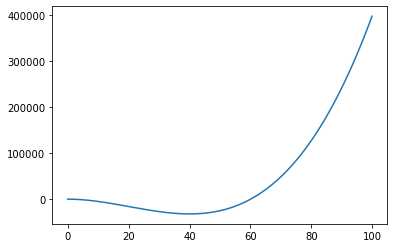

In [64]:
## https://zhuanlan.zhihu.com/p/378907443
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import math


# define aim function
def aimFunction(x):
    y = x ** 3 - 60 * x ** 2 - 4 * x + 6
    return y


x = [i / 10 for i in range(1000)]
y = [0 for i in range(1000)]
for i in range(1000):
    y[i] = aimFunction(x[i])

plt.plot(x, y)
T = 1000  # initiate temperature
Tmin = 10  # minimum value of terperature
x = np.random.uniform(low=0, high=100)  # initiate x
k = 50  # times of internal circulation
y = 0  # initiate result
t = 0  # time
while T >= Tmin:
    for i in range(k):
        # calculate y
        y = aimFunction(x)
        # generate a new x in the neighboorhood of x by transform function
        xNew = x + np.random.uniform(low=-0.055, high=0.055) * T
        if (0 <= xNew and xNew <= 100):
            yNew = aimFunction(xNew)
            if yNew - y < 0:
                x = xNew
            else:
                # metropolis principle
                p = math.exp(-(yNew - y) / T)
                r = np.random.uniform(low=0, high=1)
                if r < p:
                    x = xNew
    t += 1
    T = 1000 / (1 + t)  #降温函数，也可使用T=0.9T

print(x, aimFunction(x))

# SelectKBest, PCA之类